# A/B Project : Changing the download link to A Button

## Experiment Goal
This project is done with the purpose to prove that changing the download button to a new button design will encourage our customer<br>
to click more to our download link

<img src="button.png" alt="Button Image" width="400" height="300">

## Metrics
### Driver Metrics
For this project we chose **CTR** for our metrics, to be specific we want to see how many users click the download button to<br>
our download link

### Guardrail Metrics
For our guardrai metrics we would observe the change on our network services, e.g change in our server, significant increased<br>
in app/web latency, loading page, etc. that would potentially disrupt UX and make the trade-off not worth it.

## Variants
Control = The old button that is currently being used <br>
Treatment = A button that would direct our user to download our app <br>

## Hypotesis
We set this following to be our hypotesis

> $H_0: {CTR, Control} >= {CTR, Treatment}$ <br>
> $H_1: {CTR,  Control} < {CTR, Treatment}$ <BR>

Null hypotesis determines that there would be no difference in CTR between Control and Treatment <br>
H1 determines that Treatment would have higher CTR than control 

## Experiment Design
1. Randomization Unit = User's IP Adress
2. Target Randomization Unit = Our website visitor, regardless the visitor logged in or not.
3. Sample Size
  * Confidence Level ($\alpha$) 5%,
  * Power ($1-\beta$) 80%
  * Difference Control & Treatment ($\delta$) 1%
  * Standar Deviasi populasi ($\sigma$) 0.125 <br>

We assign those numbers because we believe the number is appropriate to set for performing A/B test, due to <br>
the size of sample that would be needed, we decided to do the project for **2 Weeks**

In [1]:
# Sample Size
delta = 0.01
std_dev = 0.125
sample_size = (16*std_dev**2)/(delta)**2
print(f'Sample needed per grup: {round(sample_size)}')
print(f'Sample nededed total : {round(2*sample_size)}')

Sample needed per grup: 2500
Sample nededed total : 5000


## Data Processing

### Importing and cleaning data

In [2]:
import pandas as pd
import numpy as np

In [3]:
#Importing Data
df = pd.read_csv('data.csv')
df.head()

,RecordID,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,1,39.13.114.2,1,2,0
1,2,13.3.25.8,1,1,0
2,3,247.8.211.8,1,1,0
3,4,124.8.220.3,0,3,0
4,5,60.10.192.7,0,2,0


In [4]:
#Checking Data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184588 entries, 0 to 184587
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   RecordID       184588 non-null  int64 
 1   IP Address     184588 non-null  object
 2   LoggedInFlag   184588 non-null  int64 
 3   ServerID       184588 non-null  int64 
 4   VisitPageFlag  184588 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 7.0+ MB


In [5]:
#Removing 'Record Id' and grouping to make one row per IP address
df.drop(['RecordID'], axis=1, inplace=True)
df = df.groupby(["IP Address", "LoggedInFlag", "ServerID"])["VisitPageFlag"].sum()
df = df.reset_index(name="TotalVisitPageFlag")

In [6]:
df[df['TotalVisitPageFlag'] == 1]

,IP Address,LoggedInFlag,ServerID,TotalVisitPageFlag
7,0.0.181.9,0,1,1
13,0.0.209.9,0,3,1
16,0.0.220.4,0,1,1
29,0.1.123.6,0,1,1
34,0.1.192.9,0,2,1
...,...,...,...,...
99725,99.8.95.8,0,2,1
99731,99.9.122.3,0,3,1
99744,99.9.199.3,0,1,1
99748,99.9.215.4,0,3,1


In [7]:
#checking if there is IP address with more than 1 visit
df["VisitPageFlag"] = df["TotalVisitPageFlag"].apply(lambda x: 1 if x != 0 else 0)
df.drop("TotalVisitPageFlag", axis=1, inplace=True)
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


In [8]:
df.duplicated().sum()

0

We decided to keep visitors who are logged in into our data. Due to our app only have been released recently <br>
we are under the assumption that our user does not aware that we are available on mobile app. For that reason <br>
we also include our user, so that the data would scope our visitors in general, both logged in and not.

In [9]:
#Potential Users
df_filtered = df[(df['LoggedInFlag'] == 0) & (df['VisitPageFlag'] == 1)]
df_filtered.count()

IP Address       9978
LoggedInFlag     9978
ServerID         9978
VisitPageFlag    9978
dtype: int64

## A/A Testing

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.stats.proportion import proportions_ztest

In [11]:
#Server Distribution to visitors
server_distribution = pd.DataFrame({
    'ServerID': df["ServerID"].value_counts().index,
    'Distribution': df["ServerID"].value_counts().values
})
server_distribution

,ServerID,Distribution
0,1,33303
1,3,33276
2,2,33184


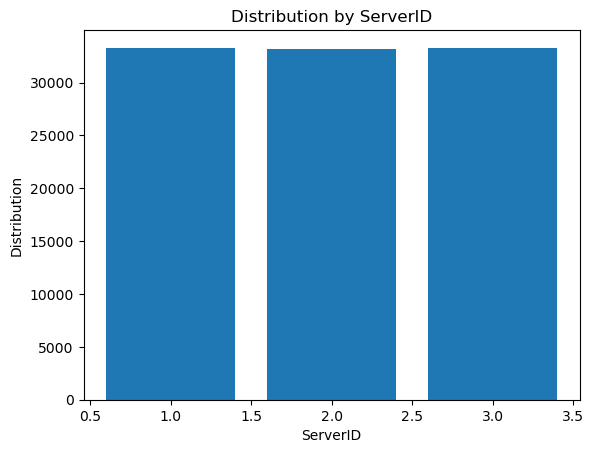

In [12]:
# Distribusi dari Server ID
plt.bar(server_distribution['ServerID'], server_distribution['Distribution'])

#labels and title
plt.xlabel('ServerID')
plt.ylabel('Distribution')
plt.title('Distribution by ServerID')

# Show the plot
plt.show()

In [13]:
# Drop Server ID, we want to treat the Data equally
data_1 = df.drop(['ServerID'], axis = 1)
data_1.head()

,IP Address,LoggedInFlag,VisitPageFlag
0,0.0.108.2,0,0
1,0.0.109.6,1,0
2,0.0.111.8,0,0
3,0.0.160.9,1,0
4,0.0.163.1,0,0


In [14]:
# Draw 25%  from sample without replacement replacement (SRS)
control_subset = data_1.sample(frac = 0.25, replace = False, random_state = 1)
treatment_subset = data_1.sample(frac = 0.25, replace = False, random_state = 111)

#Counting sample Proportion
count_visit_1c = len(control_subset[control_subset['VisitPageFlag']==1])
sample_size_1c = len(control_subset)

count_visit_1t = len(treatment_subset[treatment_subset['VisitPageFlag']==1])
sample_size_1t = len(treatment_subset)


# Cetak rerata, standar deviasi, dan jumlah sampel
c_ratio = count_visit_1c / sample_size_1c
c_obs = sample_size_1c
t_ratio = count_visit_1t / sample_size_1t
t_obs = sample_size_1t

print('Grup Control A:')
print(f'Control Visit: {count_visit_1c}')
print(f'Observasi control: {c_obs}')
print(f'CTR Control: {c_ratio}')
print('-----------------------------------')
print('Grup Treatment A:')
print(f'Control Visit: {count_visit_1t}')
print(f'Observasi control: {t_obs}')
print(f'CTR Treatment: {t_ratio}')
print('___________________________________')


print('Confidence Interval : 95%')
stat, pvalue = proportions_ztest([count_visit_1c, count_visit_1t], [sample_size_1c, sample_size_1t], alternative='smaller')
print(f"Z-statistic: {stat:0.3f}")
print(f"p-value: {pvalue:0.3f}")

from statsmodels.stats.proportion import confint_proportions_2indep

confidence_interval = confint_proportions_2indep(count1 = count_visit_1t, nobs1 = sample_size_1t,
                                                 count2 = count_visit_1c, nobs2 = sample_size_1c,
                                                 compare='diff', alpha=0.05) #difference

print(f"Confidence Interval (Upper & Lower bounds) : {confidence_interval}")

alpha = 0.05
if(pvalue <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Grup Control A:
Control Visit: 2458
Observasi control: 24941
CTR Control: 0.0985525840984724
-----------------------------------
Grup Treatment A:
Control Visit: 2446
Observasi control: 24941
CTR Treatment: 0.09807144861874023
___________________________________
Confidence Interval : 95%
Z-statistic: 0.180
p-value: 0.572
Confidence Interval (Upper & Lower bounds) : (-0.005707856057668389, 0.004745499250237824)
Decision : Fail to Reject Null Hypothesis


> $H_0: {CTR, Control} >= {CTR, Treatment}$ <br>
> $H_1: {CTR,  Control} < {CTR, Treatment}$ <BR>

In [15]:
# Perform 500 simulations
num_simulations = 500
p_values = []

for i in range(num_simulations):
    # Draw 25% from the full data without replacement (SRS)
    control_subset = data_1.sample(frac=0.25, replace=False, random_state=i)
    treatment_subset = data_1.sample(frac=0.25, replace=False, random_state=i + 500)  # Different random_state for treatment_subset
    
    # Count sample proportions for each subset
    count_visit_1c = len(control_subset[control_subset['VisitPageFlag'] == 1])
    sample_size_1c = len(control_subset)
    
    count_visit_1t = len(treatment_subset[treatment_subset['VisitPageFlag'] == 1])
    sample_size_1t = len(treatment_subset)
    
    # Perform z-test for proportions
    stat, pvalue = proportions_ztest([count_visit_1c, count_visit_1t], [sample_size_1c, sample_size_1t], alternative='smaller')
    
    # Append the p-value to the list
    p_values.append(pvalue)

# Create a DataFrame to store the p-values
result_df = pd.DataFrame({'Simulation': np.arange(1, num_simulations + 1), 'P-value': p_values})

# Print the DataFrame
result_df

,Simulation,P-value
0,1,0.745108
1,2,0.205504
2,3,0.793705
3,4,0.393391
4,5,0.193973
...,...,...
495,496,0.470447
496,497,0.950031
497,498,0.266360
498,499,0.422356


In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

cumulative distribution function (CDF) Plot

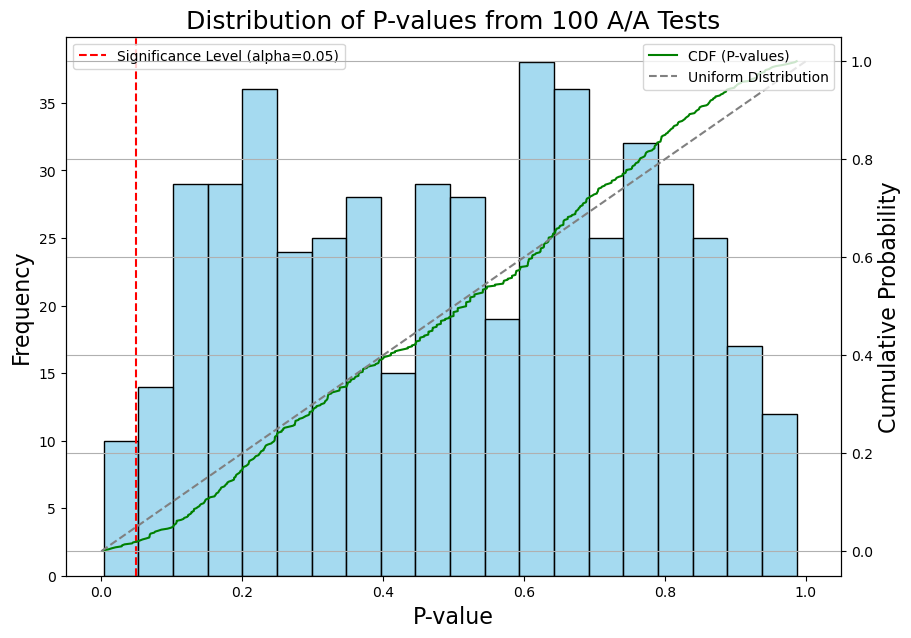

In [17]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 7))

# Visualization of p-values in histogram
ax = sns.histplot(result_df['P-value'], bins=20, kde=False, color='skyblue', edgecolor='black')

# Add a vertical line at the significance level (alpha)
alpha = 0.05
ax.axvline(x=alpha, linestyle='--', color='red', label='Significance Level (alpha=0.05)')

# Calculate the CDF of the p-values
sorted_p_values = np.sort(result_df['P-value'])
cumulative_prob = np.arange(1, len(sorted_p_values) + 1) / len(sorted_p_values)

# Plot the CDF
ax2 = ax.twinx()  # Create a twin Axes sharing the same x-axis
ax2.plot(sorted_p_values, cumulative_prob, color='green', label='CDF (P-values)')

# Add diagonal reference line for uniform distribution
ax2.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Uniform Distribution')

# Set axis labels and plot title
ax.set_xlabel('P-value', fontsize=16)
ax.set_ylabel('Frequency', fontsize=16)
ax2.set_ylabel('Cumulative Probability', fontsize=16)
plt.title('Distribution of P-values from 100 A/A Tests', fontsize=18)

# Add legend and grid
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.grid(True)

# Display the plot
plt.show()

In [18]:
# Perform kolmogorov smirnof (KS) test
result_ks = stats.kstest(rvs = result_df['P-value'],
                         cdf = 'uniform')

# save p-value of KS test
p_value = result_ks[1]
print('P-value:', p_value)

# Make decision from kolmogorof smirnov test
# We can compare p-value with alpha
# if p-value > alpha, then fail to reject H0. It means that the data is uniformly distributed

alpha = 0.05
if(p_value <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

P-value: 0.07376685360956925
Decision : Fail to Reject Null Hypothesis


We can conclude that The A/A test is success and the experiment is valid

## A/B Testing

In [19]:
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,0.0.108.2,0,1,0
1,0.0.109.6,1,1,0
2,0.0.111.8,0,3,0
3,0.0.160.9,1,2,0
4,0.0.163.1,0,2,0


In [20]:
# Adressing Control and treatment
df['ServerID'] = df['ServerID'].replace({
    1 : 'Control',
    2 : 'Control',
    3 : 'Treatment'
})
df.head()

,IP Address,LoggedInFlag,ServerID,VisitPageFlag
0,0.0.108.2,0,Control,0
1,0.0.109.6,1,Control,0
2,0.0.111.8,0,Treatment,0
3,0.0.160.9,1,Control,0
4,0.0.163.1,0,Control,0


In [21]:
df_control = df[df['ServerID'] == 'Control']
df_control.value_counts()

IP Address    LoggedInFlag  ServerID  VisitPageFlag
0.0.108.2     0             Control   0                1
251.7.217.4   0             Control   0                1
251.5.196.9   1             Control   0                1
251.5.200.4   1             Control   0                1
251.5.200.5   0             Control   0                1
                                                      ..
175.11.157.5  0             Control   0                1
175.11.200.3  1             Control   0                1
175.11.205.2  0             Control   0                1
175.11.211.9  1             Control   0                1
99.9.86.9     0             Control   0                1
Length: 66487, dtype: int64

In [22]:
df_treatment = df[df['ServerID'] == 'Treatment']
df_treatment.value_counts()

IP Address   LoggedInFlag  ServerID   VisitPageFlag
0.0.111.8    0             Treatment  0                1
250.6.168.8  1             Treatment  0                1
251.0.76.8   1             Treatment  0                1
251.0.69.9   0             Treatment  1                1
251.0.237.2  1             Treatment  0                1
                                                      ..
175.6.87.8   0             Treatment  0                1
175.6.75.7   0             Treatment  0                1
175.6.247.3  1             Treatment  0                1
175.6.241.2  0             Treatment  0                1
99.9.254.9   1             Treatment  0                1
Length: 33276, dtype: int64

In [23]:
# Draw 2500  from sample without replacement replacement (SRS)
n = 2500
control_sample = df_control.sample(n=n , replace = False)
treatment_sample = df_treatment.sample(n=n , replace = False)

#Counting sample Proportion
count_visit_control = len(control_sample[control_sample['VisitPageFlag']==1])
count_visit_treatment = len(treatment_sample[treatment_sample['VisitPageFlag']==1])
sample_size = n


# Cetak rerata, standar deviasi, dan jumlah sampel
control_propotion = count_visit_control / n
treatment_proportion = count_visit_treatment / n


print('Grup Control A:')
print(f'Control Visit: {count_visit_control}')
print(f'Observasi control: {n}')
print(f'CTR Control: {control_propotion}')
print('-----------------------------------')
print('Grup Treatment B:')
print(f'Control Visit: {count_visit_treatment}')
print(f'Observasi control: {n}')
print(f'CTR Treatment: {treatment_proportion}')
print('___________________________________')


print('Confidence Interval : 95%')
stat, pvalue = proportions_ztest([count_visit_control, count_visit_treatment], [n, n], alternative='smaller')
print(f"Z-statistic: {stat:0.3f}")
print(f"p-value: {pvalue:0.3f}")

#Confidence Interval, Alpha = 0.05
confidence_interval = confint_proportions_2indep(count1 = count_visit_control, nobs1 = n,
                                                 count2 = count_visit_treatment, nobs2 = n,
                                                 compare='diff', alpha=0.05) #difference

print(f"Confidence Interval (Upper & Lower bounds) : {confidence_interval}")

alpha = 0.05
if(pvalue <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Grup Control A:
Control Visit: 276
Observasi control: 2500
CTR Control: 0.1104
-----------------------------------
Grup Treatment B:
Control Visit: 251
Observasi control: 2500
CTR Treatment: 0.1004
___________________________________
Confidence Interval : 95%
Z-statistic: 1.151
p-value: 0.875
Confidence Interval (Upper & Lower bounds) : (-0.007043413691567413, 0.027057405486354418)
Decision : Fail to Reject Null Hypothesis


> $H_0: {CTR, Control} >= {CTR, Treatment}$ <br>
> $H_1: {CTR,  Control} < {CTR, Treatment}$ <BR>

## Two Weeks Experiment

In [24]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

def count_ctr_app(data_control, data_treatment, visit_column):
    n = len(data_control)
    
    count_visit_control = len(data_control[data_control[visit_column] == 1])
    count_visit_treatment = len(data_treatment[data_treatment[visit_column] == 1])

    control_proportion = count_visit_control / n
    treatment_proportion = count_visit_treatment / n

    stat, pvalue = proportions_ztest([count_visit_control, count_visit_treatment], [n, n], alternative='smaller')

    confidence_interval = confint_proportions_2indep(count1=count_visit_control, nobs1=n,
                                                     count2=count_visit_treatment, nobs2=n,
                                                     compare='diff', alpha=0.05)

    decision = "Reject Null Hypothesis" if pvalue < 0.05 else "Fail to Reject Null Hypothesis"

    result = {
        'Control Visit': count_visit_control,
        'Control Rate': control_proportion,
        'Treatment Visit': count_visit_treatment,
        'Treatment Rate': treatment_proportion,
        'Z-Statistic': stat,
        'P-Value': pvalue,
        '(Lower Bound)': confidence_interval[0],
        '(Upper Bound)': confidence_interval[1],
        'Decision': decision
    }

    return result

In [25]:
# Day 1
n = 1500
result_list = []
data_control = df_control.sample(n=n, replace=False)
data_treatment = df_treatment.sample(n=n, replace=False)
visit_column = 'VisitPageFlag'

result_list.append(pd.DataFrame(count_ctr_app(data_control, data_treatment, visit_column), index=['Day 1']))
final_count = pd.concat(result_list)
final_count

,Control Visit,Control Rate,Treatment Visit,Treatment Rate,Z-Statistic,P-Value,(Lower Bound),(Upper Bound),Decision
Day 1,162,0.108,142,0.094667,1.210024,0.886865,-0.008309,0.035011,Fail to Reject Null Hypothesis


In [26]:
#Day 2
data_control_day2 = df_control.sample(n=n, replace=False)
data_treatment_day2 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day2, data_treatment_day2, visit_column), index=['Day 2']))
final_count = pd.concat(result_list)
final_count

,Control Visit,Control Rate,Treatment Visit,Treatment Rate,Z-Statistic,P-Value,(Lower Bound),(Upper Bound),Decision
Day 1,162,0.108000,142,0.094667,1.210024,0.886865,-0.008309,0.035011,Fail to Reject Null Hypothesis
Day 2,188,0.125333,137,0.091333,2.995899,0.998632,0.011764,0.056308,Fail to Reject Null Hypothesis


In [27]:
#Day 3
data_control_day3 = df_control.sample(n=n, replace=False)
data_treatment_day3 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day3, data_treatment_day3, visit_column), index=['Day 3']))
final_count = pd.concat(result_list)

In [28]:
#Day 4
data_control_day4 = df_control.sample(n=n, replace=False)
data_treatment_day4 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day4, data_treatment_day4, visit_column), index=['Day 4']))
final_count = pd.concat(result_list)

In [29]:
#Day 5
data_control_day5 = df_control.sample(n=n, replace=False)
data_treatment_day5 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day5, data_treatment_day5, visit_column), index=['Day 5']))
final_count = pd.concat(result_list)

In [30]:
#Day 6
data_control_day6 = df_control.sample(n=n, replace=False)
data_treatment_day6 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day6, data_treatment_day6, visit_column), index=['Day 3']))
final_count = pd.concat(result_list)

In [31]:
#Day 7
data_control_day7 = df_control.sample(n=n, replace=False)
data_treatment_day7 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day7, data_treatment_day7, visit_column), index=['Day 7']))
final_count = pd.concat(result_list)

In [32]:
#Day 8
data_control_day8 = df_control.sample(n=n, replace=False)
data_treatment_day8 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day8, data_treatment_day8, visit_column), index=['Day 8']))
final_count = pd.concat(result_list)

In [33]:
#Day 9
data_control_day9 = df_control.sample(n=n, replace=False)
data_treatment_day9 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day9, data_treatment_day9, visit_column), index=['Day 9']))
final_count = pd.concat(result_list)

In [34]:
#Day 10
data_control_day10 = df_control.sample(n=n, replace=False)
data_treatment_day10 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day10, data_treatment_day10, visit_column), index=['Day 10']))
final_count = pd.concat(result_list)

In [35]:
#Day 11
data_control_day11 = df_control.sample(n=n, replace=False)
data_treatment_day11 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day11, data_treatment_day11, visit_column), index=['Day 11']))
final_count = pd.concat(result_list)

In [36]:
#Day 12
data_control_day12 = df_control.sample(n=n, replace=False)
data_treatment_day12 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day12, data_treatment_day12, visit_column), index=['Day 12']))
final_count = pd.concat(result_list)

In [37]:
#Day 13
data_control_day13 = df_control.sample(n=n, replace=False)
data_treatment_day13 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day13, data_treatment_day3, visit_column), index=['Day 13']))
final_count = pd.concat(result_list)

In [38]:
#Day 14
data_control_day14 = df_control.sample(n=n, replace=False)
data_treatment_day14 = df_treatment.sample(n=n, replace=False)

result_list.append(pd.DataFrame(count_ctr_app(data_control_day14, data_treatment_day14, visit_column), index=['Day 14']))
final_count = pd.concat(result_list)

## Recap

In [39]:
final_count

,Control Visit,Control Rate,Treatment Visit,Treatment Rate,Z-Statistic,P-Value,(Lower Bound),(Upper Bound),Decision
Day 1,162,0.108000,142,0.094667,1.210024,0.886865,-0.008309,0.035011,Fail to Reject Null Hypothesis
Day 2,188,0.125333,137,0.091333,2.995899,0.998632,0.011764,0.056308,Fail to Reject Null Hypothesis
Day 3,149,0.099333,140,0.093333,0.556916,0.711207,-0.015179,0.027198,Fail to Reject Null Hypothesis
Day 4,162,0.108000,131,0.087333,1.906533,0.971709,-0.000608,0.042003,Fail to Reject Null Hypothesis
Day 5,163,0.108667,135,0.090000,1.709101,0.956284,-0.002774,0.040160,Fail to Reject Null Hypothesis
Day 3,151,0.100667,138,0.092000,0.804434,0.789427,-0.012507,0.029867,Fail to Reject Null Hypothesis
Day 7,151,0.100667,141,0.094000,0.615949,0.731036,-0.014608,0.027961,Fail to Reject Null Hypothesis
Day 8,171,0.114000,130,0.086667,2.491494,0.993640,0.005822,0.048920,Fail to Reject Null Hypothesis
Day 9,159,0.106000,128,0.085333,1.924228,0.972837,-0.000412,0.041811,Fail to Reject Null Hypothesis
Day 10,163,0.108667,150,0.100000,0.776422,0.781250,-0.013264,0.030618,Fail to Reject Null Hypothesis


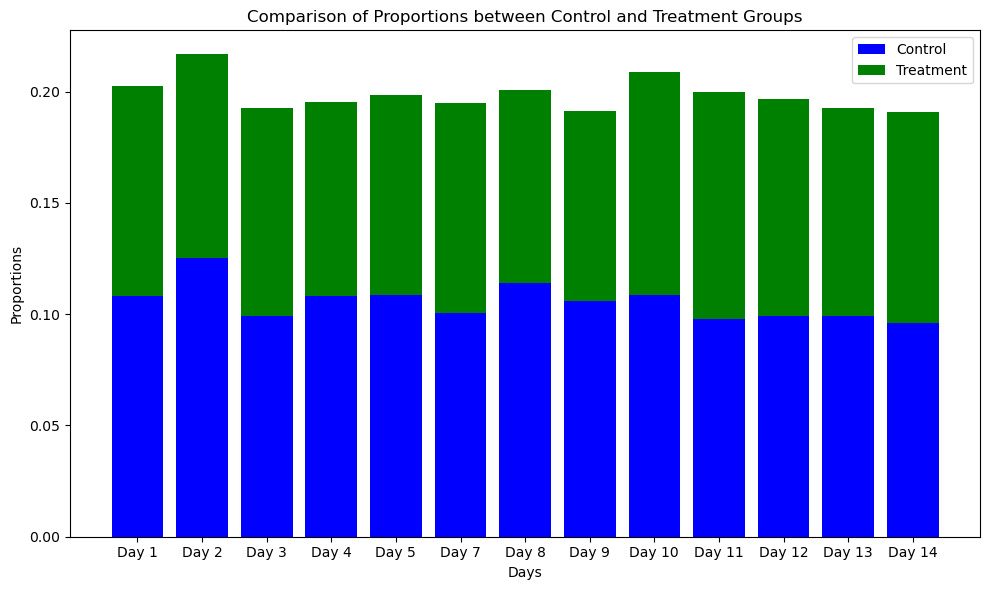

In [40]:
# Extract the required data for the plot
days = final_count.index
control_proportions = final_count['Control Rate']
treatment_proportions = final_count['Treatment Rate']

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the stacked bar chart
ax.bar(days, control_proportions, label='Control', color='b')
ax.bar(days, treatment_proportions, bottom=control_proportions, label='Treatment', color='g')

# Add labels, title, and legend
ax.set_xlabel('Days')
ax.set_ylabel('Proportions')
ax.set_title('Comparison of Proportions between Control and Treatment Groups')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

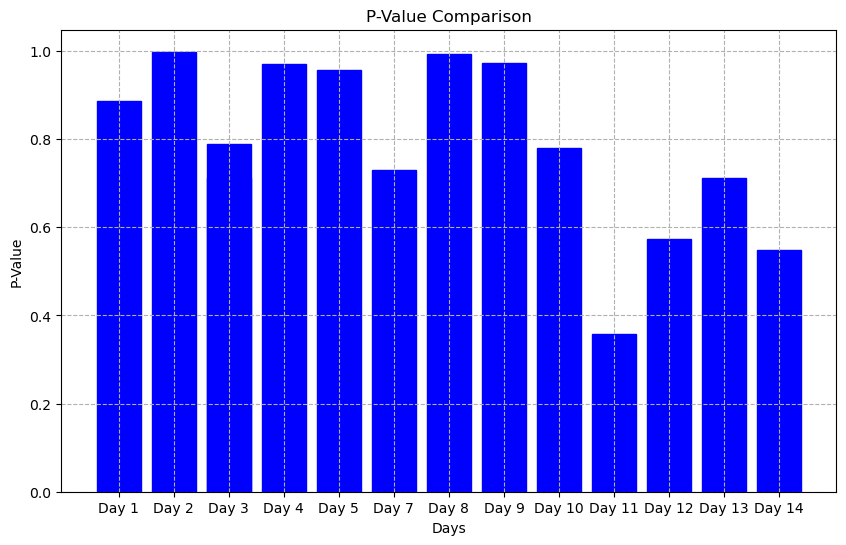

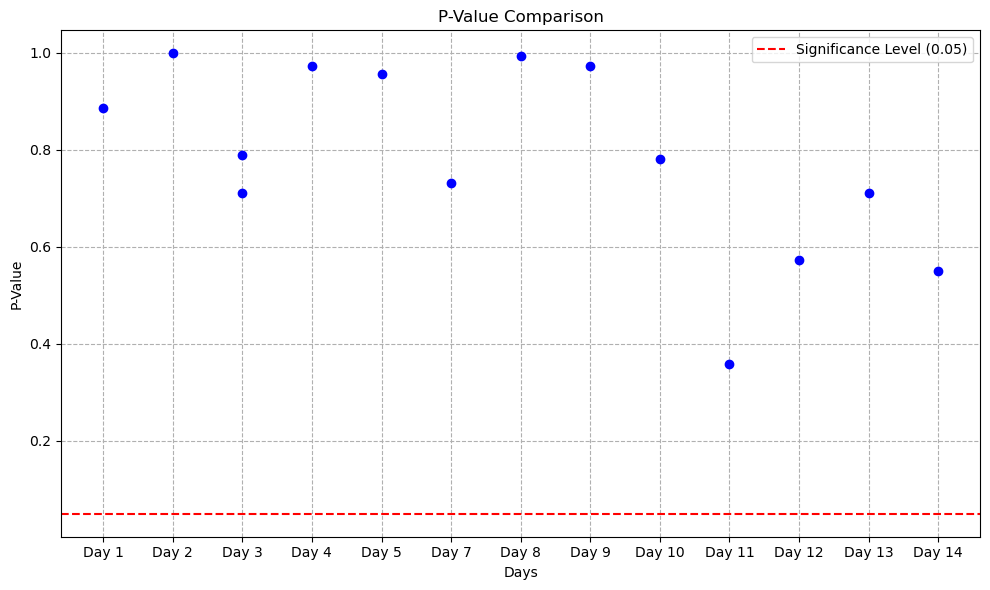

In [41]:
# Extract the required data for the plot
days = final_count.index
p_values = final_count['P-Value']

# Set up the figure and axis for the bar plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the bar plot
ax1.bar(days, p_values, color='b')

# Add labels, title, and grid
ax1.set_xlabel('Days')
ax1.set_ylabel('P-Value')
ax1.set_title('P-Value Comparison')
ax1.grid(True, linestyle='--')

# Set the significance level threshold for color-coding (e.g., 0.05)
significance_threshold = 0.05

# Color the bars based on significance
for idx, p_value in enumerate(p_values):
    color = 'r' if p_value < significance_threshold else 'b'
    ax1.get_children()[idx].set_color(color)

# Set up the figure and axis for the dot plot
fig, ax2 = plt.subplots(figsize=(10, 6))

# Plot the dot plot
ax2.plot(days, p_values, 'o', color='b')

# Add labels, title, and grid
ax2.set_xlabel('Days')
ax2.set_ylabel('P-Value')
ax2.set_title('P-Value Comparison')
ax2.grid(True, linestyle='--')

# Draw a horizontal line at the significance level threshold
ax2.axhline(significance_threshold, color='r', linestyle='--', label='Significance Level (0.05)')

# Add a legend
ax2.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [42]:
final_count

,Control Visit,Control Rate,Treatment Visit,Treatment Rate,Z-Statistic,P-Value,(Lower Bound),(Upper Bound),Decision
Day 1,162,0.108000,142,0.094667,1.210024,0.886865,-0.008309,0.035011,Fail to Reject Null Hypothesis
Day 2,188,0.125333,137,0.091333,2.995899,0.998632,0.011764,0.056308,Fail to Reject Null Hypothesis
Day 3,149,0.099333,140,0.093333,0.556916,0.711207,-0.015179,0.027198,Fail to Reject Null Hypothesis
Day 4,162,0.108000,131,0.087333,1.906533,0.971709,-0.000608,0.042003,Fail to Reject Null Hypothesis
Day 5,163,0.108667,135,0.090000,1.709101,0.956284,-0.002774,0.040160,Fail to Reject Null Hypothesis
Day 3,151,0.100667,138,0.092000,0.804434,0.789427,-0.012507,0.029867,Fail to Reject Null Hypothesis
Day 7,151,0.100667,141,0.094000,0.615949,0.731036,-0.014608,0.027961,Fail to Reject Null Hypothesis
Day 8,171,0.114000,130,0.086667,2.491494,0.993640,0.005822,0.048920,Fail to Reject Null Hypothesis
Day 9,159,0.106000,128,0.085333,1.924228,0.972837,-0.000412,0.041811,Fail to Reject Null Hypothesis
Day 10,163,0.108667,150,0.100000,0.776422,0.781250,-0.013264,0.030618,Fail to Reject Null Hypothesis


In [43]:
#Final result
n_final = 1500 * len(final_count)
control_final = final_count['Control Visit'].sum()
treatment_final = final_count['Treatment Visit'].sum()

# Rate
control_rate_final = control_final / n_final
treatment_rate_final = treatment_final / n_final


print('Grup Control A:')
print(f'Control Visit: {control_final}')
print(f'Observasi control: {n_final}')
print(f'CTR Control: {control_rate_final}')
print('-----------------------------------')
print('Grup Treatment B:')
print(f'Control Visit: {treatment_final}')
print(f'Observasi control: {n_final}')
print(f'CTR Treatment: {treatment_rate_final}')
print('___________________________________')


print('Confidence Interval : 95%')
stat, pvalue = proportions_ztest([control_final, treatment_final], [n_final, n_final], alternative='smaller')
print(f"Z-statistic: {stat:0.3f}")
print(f"p-value: {pvalue:0.3f}")

#Confidence Interval, Alpha = 0.05
confidence_interval = confint_proportions_2indep(count1 = control_final, nobs1 = n_final,
                                                 count2 = treatment_final, nobs2 = n_final,
                                                 compare='diff', alpha=0.05) #difference

print(f"Confidence Interval (Upper & Lower bounds) : {confidence_interval}")

alpha = 0.05
if(pvalue <  alpha):
  print("Decision : Reject Null Hypothesis")
else:
  print("Decision : Fail to Reject Null Hypothesis")

Grup Control A:
Control Visit: 2208
Observasi control: 21000
CTR Control: 0.10514285714285715
-----------------------------------
Grup Treatment B:
Control Visit: 1953
Observasi control: 21000
CTR Treatment: 0.093
___________________________________
Confidence Interval : 95%
Z-statistic: 4.165
p-value: 1.000
Confidence Interval (Upper & Lower bounds) : (0.006429507347285182, 0.017858724735969663)
Decision : Fail to Reject Null Hypothesis


### SRM TEST
H0 = sample size control = sample size treatment (no SRM) <br>
H1 = sample size control =! sample size treatment (SRM)

In [44]:
srm_control = n * len(final_count['Control Visit'])
srm_treatment = n * len(final_count['Treatment Visit'])
srm_size = pd.DataFrame({
    'Group' : ['Control', 'Treatment'],
    'Size Obs' : [srm_control, srm_treatment],
    'Exptd Obs' : [((srm_control + srm_treatment)/2),((srm_control + srm_treatment)/2)]
})
srm_size

,Group,Size Obs,Exptd Obs
0,Control,21000,21000.0
1,Treatment,21000,21000.0


### Chi-square and Degree of Freedom

In [45]:
# Calculate chi-square statistic and Degree of Freedom
dof = (2-1) * (2-1) #2 jenis group dan dua jenis kolom (observed and expected)
chi_sqr = [((srm_size['Size Obs'] - srm_size['Exptd Obs'])**2) / srm_size['Exptd Obs']][0].sum()
chi_sqr

0.0

It means that both Control and Treatment have the same distribution

**We Reject H0 if** :
- chi-square statistic > chi-square critical value **or**
- p-value < siqnificance level

In [46]:
#Chi-square Critical
chi_sqr_critical = stats.chi2.ppf(1-alpha, df=dof)
print("Chi-Square Critical", chi_sqr_critical)
print("Chi-Square Statistic", chi_sqr)

if chi_sqr > chi_sqr_critical:
    print("Reject H0 : Sample Ratio Mismatch (SRM)")
else:
    print("Fail to Reject H0 : No Sample Ratio Mismatch (No SRM)")

Chi-Square Critical 3.841458820694124
Chi-Square Statistic 0.0
Fail to Reject H0 : No Sample Ratio Mismatch (No SRM)


In [47]:
#P-Value 
pval = stats.chi2.sf(chi_sqr, df=dof)
print('Pi-value', pval)
print('Significance Level', alpha)

if pval < alpha:
    print("Reject H0 : Sample Ratio Mismatch (SRM)")
else:
    print("Fail to Reject H0 : No Sample Ratio Mismatch (No SRM)")

Pi-value 1.0
Significance Level 0.05
Fail to Reject H0 : No Sample Ratio Mismatch (No SRM)


## Decision

> $H_0: \mu_{A, Control} >= \mu_{A, Treatment}$ <br>
> $H_1: \mu_{A, Control} < \mu_{A, Treatment}$

Decision : 
After performing 14 day of testing, it is safe to assume that the right decision is to **Fail to Reject Null Hypothesis**. <br>
This assumption also backed if we look at the proportion comparison between control and treatment